In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
import numpy as np

In [2]:
from __future__ import print_function
import time, os, glob
import ROOT
from array import array
#from hist_utils import *
import CMS_lumi

Welcome to JupyROOT 6.20/02


In [3]:
def make_pdf(h):

    sumOverY = {}
    for ix in range(1, h.GetNbinsX()+1):
        sumOverY[ix] = sum([h.GetBinContent(ix, iy_) for iy_ in range(1, h.GetNbinsY()+1)])
        for iy in range(1, h.GetNbinsY()+1):
            binc = h.GetBinContent(ix, iy)
            if sumOverY[ix] > 0.:
                h.SetBinContent(ix, iy, binc/sumOverY[ix])

    return h

def set_hist(h, c, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.14)
    #c.SetRightMargin(0.07)
    #c.SetBottomMargin(0.12)
    #c.SetTopMargin(0.07)
    c.SetLeftMargin(0.16)
    c.SetRightMargin(0.08)
    c.SetBottomMargin(0.15)
    c.SetTopMargin(0.07)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    h.GetXaxis().SetLabelFont(42)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.9)
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetTitleFont(42)

    h.GetYaxis().SetLabelSize(0.04)
    h.GetYaxis().SetLabelFont(42)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleFont(42)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    h.SetTitleFont(42)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    return h, c

In [4]:
img_inputs = {}
img_inputs['2016'] = [
    'data2016-Run2016B_mantuple.root',
    'data2016-Run2016C_mantuple.root',
    'data2016-Run2016D_mantuple.root',
    'data2016-Run2016E_mantuple.root',
    'data2016-Run2016F_mantuple.root',
    'data2016-Run2016G_mantuple.root',
    'data2016-Run2016H_mantuple.root',
]
img_inputs['2017'] = [
    'data2017-Run2017B_mantuple.root',
    'data2017-Run2017C_mantuple.root',
    'data2017-Run2017D_mantuple.root',
    'data2017-Run2017E_mantuple.root',
    'data2017-Run2017F_mantuple.root',
]
img_inputs['2018'] = [
    'data2018-Run2018A_mantuple.root',
    'data2018-Run2018B_mantuple.root',
    'data2018-Run2018C_mantuple.root',
    'data2018-Run2018D0_mantuple.root',
    'data2018-Run2018D1_mantuple.root',
    'data2018-Run2018D2_mantuple.root',
    'data2018-Run2018D3_mantuple.root',
]

kdata = '2017'
#kmc = '2016'
kmc = '2018'
samples = [kdata, kmc]
ma, pt, eta, pu = {}, {}, {}, {}
runs = {}
bdt = {}
#eta_range = 'cntr'
#eta_range = 'mid'
#eta_range = 'fwd'
eta_range = None
#era = 'ZeeSel-Era16Feb2021-Zeev1' #massreg paper only
#era = 'ZeeSel-Era16Feb2021-Zeev2' #h4g
ml_model = 'ep90' # massreg paper only
#ml_model = 'ep80-h4g' # h4g

print('>> Doing |eta| range:',eta_range)

for s in samples:
    
    print('>> For sample:',s)
        
    year = s
    eos_basedir = 'root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/%s/Era%s_15Mar2021_CLUSv1/skim/%s'%(year, year, ml_model)
    print(img_inputs[year][0])
    print('.. N input files: %d'%(len(img_inputs[year])))
    assert len(img_inputs[year]) > 0

    tree = ROOT.TChain("mantuple")
    for fi in img_inputs[year]:
        fname = '%s/%s'%(eos_basedir,fi)
        print('   .. input file:',fname)
        tree.Add(fname)
        #break
    nEvts = tree.GetEntries()
    print('.. N events: %d'%nEvts)

    ###############################
    # Event loop

    iEvtStart = 0
    iEvtEnd   = nEvts
    #iEvtEnd   = 10000000#100#50000#10
    print(".. Processing entries: [",iEvtStart,"->",iEvtEnd,")")

    nWrite = 0
    ma[s], pt[s], eta[s], pu[s] = [], [], [], []
    runs[s] = []
    bdt[s] = []
    for iEvt in range(iEvtStart,iEvtEnd):

        # Initialize event
        if iEvt%1e6==0: print('   ..',iEvt,'/',iEvtEnd-iEvtStart)
        evt_status = tree.GetEntry(iEvt)

        if tree.pt1 >= 35.: continue
        if tree.mgg >= 100.: continue
        #'''
        # for massreg paper
        if tree.nRecoPho != 2: continue
        if tree.bdt1 <= -0.92: continue
        if tree.chiso1/tree.pt1 >= 0.3: continue
        if tree.sieie1 >= 0.013: continue #0.011
        #'''
        '''
        # for h4g paper
        #if tree.nRecoPho != 2: continue
        if tree.bdt1 <= -0.96: continue
        if tree.chiso1/tree.pt1 >= 0.07: continue
        #if tree.sieie1 >= 0.013: continue #0.011 if left commented
        '''
        
        # Store
        eta_ = tree.eta1
        if eta_range == 'cntr':
            if abs(eta_) > 0.5: continue
        elif eta_range == 'mid':
            if abs(eta_) <= 0.5 or abs(eta_) > 1.00: continue
        elif eta_range == 'fwd':
            if abs(eta_) <= 1.0 or abs(eta_) > 1.44: continue
        ma[s].append(tree.ma1)
        pt[s].append(tree.pt1)
        eta[s].append(eta_)
        pu[s].append(tree.pu)
        runs[s].append(tree.run)
        bdt[s].append(tree.bdt1)

        nWrite += 1

    print('.. N selected: %d / %d'%(nWrite, iEvtEnd-iEvtStart))
    
    ma[s] = np.array(ma[s])
    pt[s] = np.array(pt[s])
    eta[s] = np.array(eta[s])
    pu[s] = np.array(pu[s])
    runs[s] = np.array(runs[s])
    bdt[s] = np.array(bdt[s])
    assert len(ma[s] == pt[s])
    print('.. N cands:',len(ma[s]))
    print('.. ma[:5]:',ma[s][:5])
    print('.. pt[:5]:',pt[s][:5])
    print('.. eta[:5]:',eta[s][:5])
    print('.. pu[:5]:',pu[s][:5])
    print('.. run[:5]:',runs[s][:5])
    print('.. bdt[:5]:',bdt[s][:5])
    print('=============================')

print('>> Done.')

>> Doing |eta| range: None
>> For sample: 2017
data2017-Run2017B_mantuple.root
.. N input files: 5
   .. input file: root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90/data2017-Run2017B_mantuple.root
   .. input file: root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90/data2017-Run2017C_mantuple.root
   .. input file: root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90/data2017-Run2017D_mantuple.root
   .. input file: root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90/data2017-Run2017E_mantuple.root
   .. input file: root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90/data2017-Run2017F_mantuple.root
.. N events: 16034076
.. Processing entries: [ 0 -> 16034076 )
   .. 0 / 16034076
   .. 1000000 / 16034076
   .. 2000000 / 16034076
   .. 3000000 / 16034076
   .. 4000000 / 16034076
   .

In [5]:
for s in samples:
    print('run[%s] min:%d max:%d'%(s, np.min(runs[s]), np.max(runs[s])))

run[2017] min:297050 max:306460
run[2018] min:315264 max:325172


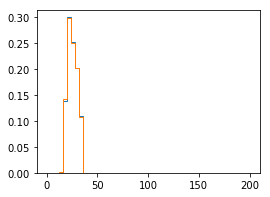

34.9999885559082 34.99999237060547
10.00078296661377 10.002291679382324


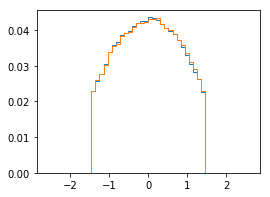

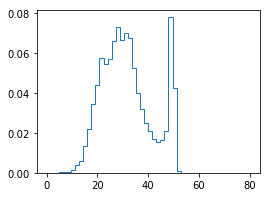

55.222984313964844 -1.0


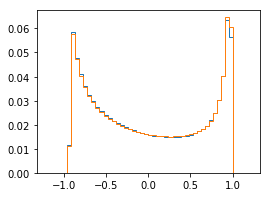

In [6]:
plt.rcParams["figure.figsize"] = (4,3)

plt.hist(pt[kdata], histtype='step', bins=50, range=(0., 200.), weights=np.ones_like(pt[kdata])/len(pt[kdata]))
plt.hist(pt[kmc], histtype='step', bins=50, range=(0., 200.), weights=np.ones_like(pt[kmc])/len(pt[kmc]))
plt.show()
print(pt[kdata].max(), pt[kmc].max())
print(pt[kdata].min(), pt[kmc].min())

plt.hist(eta[kdata], histtype='step', bins=50, range=(-2.6, 2.6), weights=np.ones_like(eta[kdata])/len(eta[kdata]))
plt.hist(eta[kmc], histtype='step', bins=50, range=(-2.6, 2.6), weights=np.ones_like(eta[kmc])/len(eta[kmc]))
plt.show()

plt.hist(pu[kdata], histtype='step', bins=50, range=(0., 80.), weights=np.ones_like(pu[kdata])/len(pu[kdata]))
plt.hist(pu[kmc], histtype='step', bins=50, range=(0., 80.), weights=np.ones_like(pu[kmc])/len(pu[kmc]))
plt.show()

print(pu[kdata].max(), pu[kmc].max())

plt.hist(bdt[kdata], histtype='step', bins=50, range=(-1.2, 1.2), weights=np.ones_like(bdt[kdata])/len(bdt[kdata]))
plt.hist(bdt[kmc], histtype='step', bins=50, range=(-1.2, 1.2), weights=np.ones_like(bdt[kmc])/len(bdt[kmc]))
plt.show()

In [7]:
pt_bins_ = {}
pt_bins_[0] = np.arange(17, 35+1, 1)
#pt_bins_[0] = [10]
#pt_bins_[1] = np.arange(20, 90, 2)
#pt_bins_[2] = np.arange(90, 140, 10)
#pt_bins_[3] = np.arange(140, 180, 20)
#pt_bins_[4] = np.arange(180, 1500+1320, 1320)
pt_bins = [pt_bins_[i] for i in pt_bins_]
pt_bins = np.concatenate(pt_bins).flatten()
pt_bins
#print(pt['data2017'].max())

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [8]:
def sg_bg(x, par):

    arg = (x[0] - par[1])/par[2] if par[2] != 0. else 0.
    sgval = par[0]*ROOT.TMath.Exp(-0.5*arg*arg)

    bgval = par[3] + par[4]*x[0] + par[5]*x[0]*x[0]
    #bgval = ROOT.TMath.Exp(par[3] + par[4]*x[0])
    #arg2 = (x[0] - par[4])/par[5] if par[5] != 0. else 0.
    #bgval = par[3]*ROOT.TMath.Exp(-0.5*arg2*arg2)

    #fitval = sgval
    fitval = sgval + bgval
    return fitval

def fit_sg_bg(h, k):

    c = ROOT.TCanvas(k, k, 400, 400)
    h[k].Draw('hist')
    c.Draw()

    ib_max = h[k].GetMaximumBin()
    ib_off = 10
    ma_ctr = h[k].GetXaxis().GetBinLowEdge(ib_max)
    ma_lo = h[k].GetXaxis().GetBinLowEdge(ib_max-ib_off)
    ma_hi = h[k].GetXaxis().GetBinLowEdge(ib_max+ib_off)
    print(ib_max, ma_ctr)
    print(ma_lo, ma_hi)

    flo, fhi = ma_lo, ma_hi
    #flo, fhi = 0.04, 0.3
    #flo, fhi = 0.11, 0.23
    #flo, fhi = 0.12, 0.22
    #plo, phi = 0.0, 0.4
    plo, phi = ma_lo, ma_hi

    kcombo = k+'combo'
    h[kcombo] = ROOT.TF1('combo', sg_bg, plo, phi, 6)
    h[kcombo].SetParameter(1,0.15) # mean
    h[kcombo].SetParameter(2,0.5) # sigma
    h[kcombo].SetParLimits(1,0.1,0.2)
    h[kcombo].SetParLimits(2,0.,0.1)
    #h[kcombo].SetParLimits(3,5.,15.)
    #h[kcombo].SetParLimits(4,-5.,0.)
    #h[kcombo].SetParLimits(5,0.,1.e6)
    #h[kcombo].SetParLimits(3,0.,1.e5)
    #h[kcombo].SetParLimits(4,0.0,0.1)
    h[kcombo].SetParLimits(5,0.,1.)
    h[kcombo].SetLineColor(14)
    #h[kcombo].SetParNames("sg-cons","sg-mean","sg-sigma", 'bg-x0', 'bg-x1')
    h[kcombo].SetParNames("sg-cons","sg-mean","sg-sigma", 'bg-x0', 'bg-x1', 'bg-x2')
    h[k].Fit('combo', '', '', flo, fhi)
    h[kcombo].Draw('same')
    chi2 = h[kcombo].GetChisquare()
    ndof = h[kcombo].GetNDF()
    pval = h[kcombo].GetProb()
    print('chi2 / ndf: %f / %f = %f'%(chi2, ndof, chi2/ndof))
    params_combo = array('d',[0.,0.,0.,0.,0.,0.])
    h[kcombo].GetParameters(params_combo)
    #print(params_combo)
    print('!!! %s: mean:%f MeV, sigma:%f MeV'%(k, params_combo[1]*1.e3, params_combo[2]*1.e3))

    #'''
    ksg = k+'sg'
    h[ksg] = ROOT.TF1("sg","gaus", plo, phi)
    for i in range(3):
        h[ksg].FixParameter(i, params_combo[i])
    h[ksg].SetLineColor(2)
    h[ksg].Draw('same')

    kbg = k+'bg'
    h[kbg] = ROOT.TF1("bg","pol2", plo, phi)
    #bg = ROOT.TF1("bg","expo", plo, phi)
    for i in range(3):
        h[kbg].FixParameter(i, params_combo[i+3])
    h[kbg].SetLineColor(4)
    h[kbg].Draw('same')
    #'''

    c.cd()
    c.Draw()

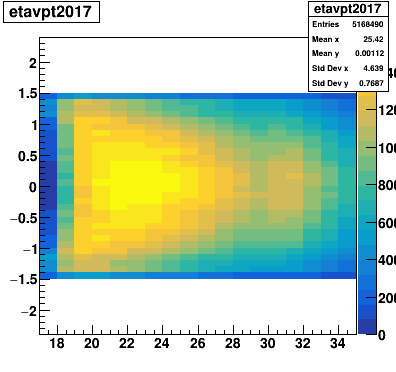

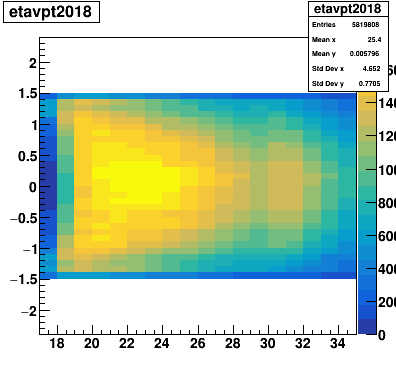

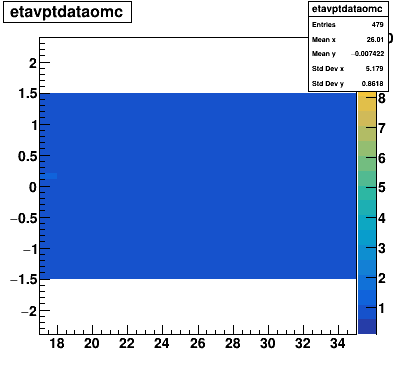

In [9]:
#'''
h, c = {}, {}

eta_edge = 2.4
#pt_lo, pt_hi = 20., 200.

s = kdata
k = 'etavpt'+s
#h[k] = ROOT.TH2F(k, k, 50, pt_lo, pt_hi, 48, -eta_edge, eta_edge)
h[k] = ROOT.TH2F(k, k, len(pt_bins)-1, array('d', pt_bins), 48, -eta_edge, eta_edge)
c[k] = ROOT.TCanvas(k, k, 400, 400)
i = 0
for p,e in zip(pt[s], eta[s]):
    h[k].Fill(p, e)
    i += 1
    #if i > 10000: break
h[k].Draw('COL Z')
c[k].Draw()

s = kmc
k = 'etavpt'+s
#h[k] = ROOT.TH2F(k, k, 50, pt_lo, pt_hi, 48, -eta_edge, eta_edge)
h[k] = ROOT.TH2F(k, k, len(pt_bins)-1, array('d', pt_bins), 48, -eta_edge, eta_edge)
c[k] = ROOT.TCanvas(k, k, 400, 400)
i = 0
for p,e in zip(pt[s], eta[s]):
    h[k].Fill(p, e)
    i += 1
    #if i > 10000: break
h[k].Draw('COL Z')
c[k].Draw()
#'''
#'''
k = 'etavptdataomc'
#h[k] = ROOT.TH2F(k, k, len(pt_bins)-1, array('d', pt_bins), 48, -eta_edge, eta_edge)
c[k] = ROOT.TCanvas(k, k, 400, 400)
h[k] = h['etavpt%s'%kdata].Clone()
h[k].SetName(k)
h[k].SetTitle(k)
h[k].Divide(h['etavpt%s'%kmc])
#h[k].GetXaxis().SetRangeUser(10., 100.)
h[k].SetMaximum(10.)
h[k].SetMinimum(1./10.)
h[k].Draw('COL Z')
c[k].Draw()
#'''

In [10]:
def get_ptetawgt(pt_, eta_, h, ceil=10.):

    ipt_  = h.GetXaxis().FindBin(pt_)
    ieta_ = h.GetYaxis().FindBin(eta_)
    wgt = h.GetBinContent(ipt_, ieta_)
    if wgt > ceil:
        wgt = ceil

    return wgt

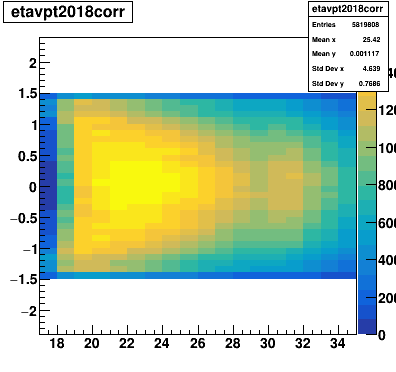

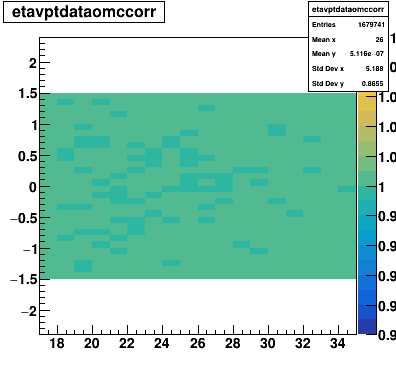

In [11]:
s = kmc
k = 'etavpt'+s+'corr'
#h[k] = ROOT.TH2F(k, k, 50, pt_lo, pt_hi, 48, -eta_edge, eta_edge)
h[k] = ROOT.TH2F(k, k, len(pt_bins)-1, array('d', pt_bins), 48, -eta_edge, eta_edge)
c[k] = ROOT.TCanvas(k, k, 400, 400)
i = 0
for p,e in zip(pt[s], eta[s]):
    #h[k].Fill(p, e)
    h[k].Fill(p, e, get_ptetawgt(p, e, h['etavptdataomc']))
    i += 1
    #if i > 10000: break
h[k].Draw('COL Z')
c[k].Draw()
#'''
#'''
k = 'etavptdataomc'+'corr'
#h[k] = ROOT.TH2F(k, k, len(pt_bins)-1, array('d', pt_bins), 48, -eta_edge, eta_edge)
c[k] = ROOT.TCanvas(k, k, 400, 400)
h[k] = h['etavpt%s'%kdata].Clone()
h[k].SetName(k)
h[k].SetTitle(k)
h[k].Divide(h['etavpt%scorr'%kmc])
#h[k].GetXaxis().SetRangeUser(10., 100.)
h[k].SetMaximum(1.+0.1)
h[k].SetMinimum(1.-0.1)
h[k].Draw('COL Z')
c[k].Draw()
#'''

4915060.92326
133.339035034
33 0.16
0.06 0.26
chi2 / ndf: 43.388284 / 14.000000 = 3.099163
!!! 2018nopucorr: mean:170.227738 MeV, sigma:39.396653 MeV
4918513.0
152.0
34 0.17
0.07 0.27
chi2 / ndf: 70.088845 / 14.000000 = 5.006346
!!! 2017: mean:169.906308 MeV, sigma:39.383749 MeV
 FCN=43.3883 FROM MIGRAD    STATUS=CONVERGED     729 CALLS         730 TOTAL
                     EDM=1.04239e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  sg-cons      3.74795e+04   2.19901e+02   3.38114e-01  -3.51344e-06
   2  sg-mean      1.70228e-01   2.24122e-04   1.03323e-05  -1.92376e-01
   3  sg-sigma     3.93967e-02   3.31691e-04   7.69314e-06  -2.36052e-01
   4  bg-x0        5.80040e+04   2.35865e+02   1.83201e-01  -3.85933e-06
   5  bg-x1       -1.81372e+04   1.54330e+03   1.07563e+00  -1.06959e-06
   6  bg-x2        6.08030e-07   5.48190e-01   5.00000

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 2018nopucorr
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


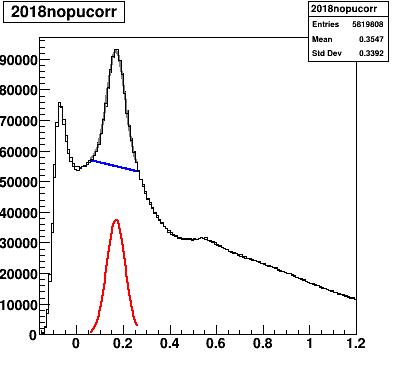

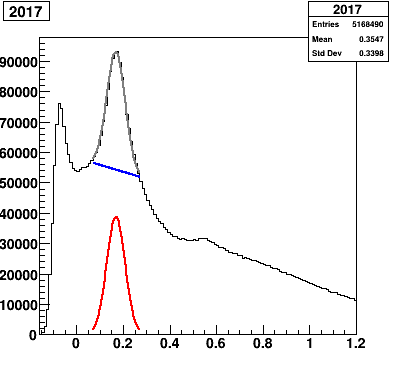

In [12]:
#h, c = {}, {}

#dM = 25
dM = 10
#dM = 100
ma_bins = np.arange(0,1400+dM,dM)-200
#ma_bins = np.arange(150,350+dM,dM)-200
#ma_bins = list(range(0,1200+dM,dM))
#ma_bins = [-400]+ma_bins
#ma_bins = [-400, -200]+ma_bins
ma_bins = [float(m)/1.e3 for m in ma_bins]
ma_bins = ma_bins[4:]
#print(len(ma_bins))
n_ma_bins = len(ma_bins)-1
ma_bins = array('d', ma_bins)
#print(ma_bins)

pu_dummy = 20.

k = kmc+'nopucorr'
#h[k] = ROOT.TH1F(k, k, 48, 0., 1.2)
#h[k] = ROOT.TH1F(k, k, 56, -0.2, 1.2)
h[k] = ROOT.TH1F(k, k, n_ma_bins, ma_bins)
c[k] = ROOT.TCanvas(k, k, 400, 400)
kpu = k+'pu'
h[kpu] = ROOT.TH1F(kpu, kpu, 20, 0., 100.)
for i,m in enumerate(ma[kmc]):
    #if i+1 >= 100000: break
    #m = (1./0.97)*(m - 0.006)
    #m = 1.036*m - 0.005
    #m = 0.946*m
    #m = 1.01*np.random.normal(m, 0.012) # with correction
    #h[k].Fill(m, wgt['DYToEE'][i])
    #h[k].Fill(m)
    wgt = get_ptetawgt(pt[kmc][i], eta[kmc][i], h['etavptdataomc'])
    h[k].Fill(m, wgt)
    #h[kpu].Fill(pu[kmc][i], wgt)
    h[kpu].Fill(pu_dummy, wgt)
h[k].Draw("hist")
c[k].cd()
c[k].Draw()
print(h[k].Integral())
print(h[k].GetBinContent(1))
fit_sg_bg(h, k)

k = kdata
#h[k] = ROOT.TH1F(k, k, 48, 0., 1.2)
#h[k] = ROOT.TH1F(k, k, 56, -0.2, 1.2)
h[k] = ROOT.TH1F(k, k, n_ma_bins, ma_bins)
#c[k] = ROOT.TCanvas(k, k, 600, 400)
kpu = k+'pu'
h[kpu] = ROOT.TH1F(kpu, kpu, 20, 0., 100.)
for i,m in enumerate(ma[k]):
    #if i+1 >= 100000: break
    h[k].Fill(m)
    #h[kpu].Fill(pu[k][i])
    h[kpu].Fill(pu_dummy)
#h[k].Draw("hist")
h[k].Draw("hist same")
#c[k].Draw()
print(h[k].Integral())
print(h[k].GetBinContent(1))
fit_sg_bg(h, k)

In [13]:
print(h[kdata].GetMaximum())
print(h[kdata].GetMaximumBin())
print(h[kdata].GetXaxis().FindBin(0.))
print(ma_bins)
print(ma_bins[21-1])
print(ma_bins[25-1])
print(ma_bins[25+4-1])
#print(ma_bins[10:34])
print(ma_bins[26:47])

93328.0
34
17
array('d', [-0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2])
0.04
0.08
0.12
array('d', [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3]

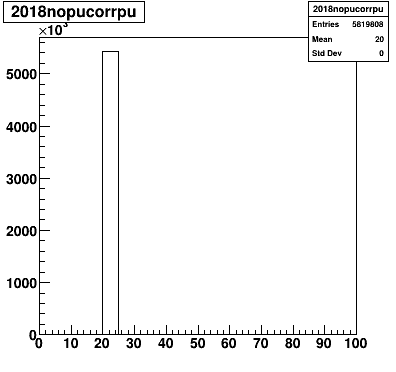

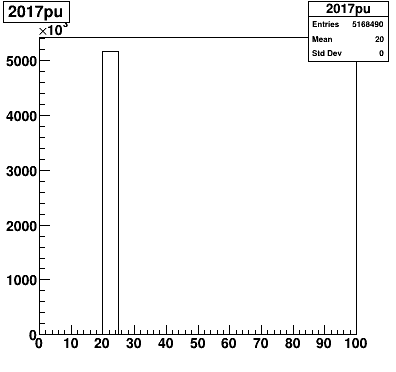

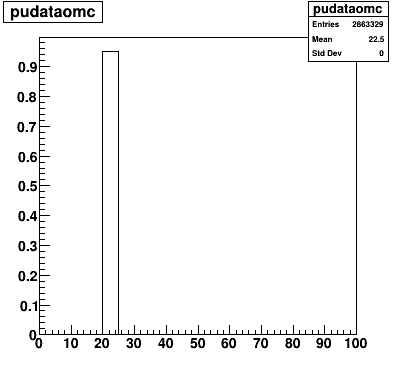

In [14]:
k = kmc+'nopucorr'
kpu = k+'pu'
c[kpu] = ROOT.TCanvas(kpu, kpu, 400, 400)
h[kpu].Draw("hist")
c[kpu].Draw()

k = kdata
kpu = k+'pu'
c[kpu] = ROOT.TCanvas(kpu, kpu, 400, 400)
h[kpu].Draw("hist")
c[kpu].Draw()

k = 'pudataomc'
c[k] = ROOT.TCanvas(k, k, 400, 400)
h[k] = h['%spu'%kdata].Clone()
h[k].SetName(k)
h[k].SetTitle(k)
h[k].Divide(h[kmc+'nopucorr'+'pu'])
h[k].Draw('hist')
c[k].Draw()

In [15]:
def get_puwgt(pu_, h):
    ipu_ = h.GetXaxis().FindBin(pu_)
    wgt = h.GetBinContent(ipu_)
    #return wgt
    return 1.

In [16]:
hdata, _ = np.histogram(ma[kdata], bins=ma_bins)
print(hdata.sum())

dywgts_pteta_pu = [get_ptetawgt(pt[kmc][i], eta[kmc][i], h['etavptdataomc'])*get_puwgt(pu[kmc][i], h['pudataomc']) for i,_ in enumerate(ma[kmc])]
print(len(dywgts_pteta_pu), len(ma[kmc]))
print(dywgts_pteta_pu[:5])

4918513
5819808 5819808
[0.9044712781906128, 0.8235890865325928, 0.8967753052711487, 0.867337167263031, 0.88559889793396]


In [17]:
print(h.keys())

['2018nopucorrpu', '2017combo', '2018nopucorrcombo', '2017bg', '2017pu', 'etavptdataomccorr', 'etavpt2017', 'etavpt2018corr', 'pudataomc', '2018nopucorrsg', '2018nopucorrbg', '2017', 'etavptdataomc', 'etavpt2018', '2017sg', '2018nopucorr']


4915060.92326
4918513.0
133.339035034
33 0.16
0.06 0.26
chi2 / ndf: 43.388284 / 14.000000 = 3.099163
!!! 2018: mean:170.227738 MeV, sigma:39.396653 MeV
 FCN=43.3883 FROM MIGRAD    STATUS=CONVERGED     729 CALLS         730 TOTAL
                     EDM=1.04239e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  sg-cons      3.74795e+04   2.19901e+02   3.38114e-01  -3.51344e-06
   2  sg-mean      1.70228e-01   2.24122e-04   1.03323e-05  -1.92376e-01
   3  sg-sigma     3.93967e-02   3.31691e-04   7.69314e-06  -2.36052e-01
   4  bg-x0        5.80040e+04   2.35865e+02   1.83201e-01  -3.85933e-06
   5  bg-x1       -1.81372e+04   1.54330e+03   1.07563e+00  -1.06959e-06
   6  bg-x2        6.08030e-07   5.48190e-01   5.00000e-01   4.81489e-08


Warning in <TCanvas::Constructor>: Deleting canvas with same name: 2018
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


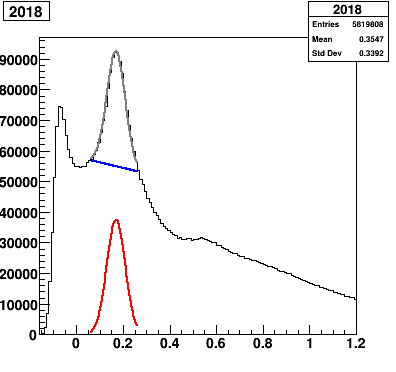

In [18]:
k = kmc
scale_ = 1.#028
smear_ = 0.#008 #GeV
h[k] = ROOT.TH1F(k, k, n_ma_bins, ma_bins)
c[k] = ROOT.TCanvas(k, k, 400, 400)
for i,m in enumerate(ma[k]):
    wgt = get_ptetawgt(pt[k][i], eta[k][i], h['etavptdataomc'])*get_puwgt(pu[k][i], h['pudataomc'])
    h[k].Fill(m, wgt)
    #h[k].Fill(scale_*np.random.normal(m, smear_), wgt)
h[k].Draw("hist")
c[k].cd()
c[k].Draw()
print(h[k].Integral())
print(h[kdata].Integral())
print(h[k].GetBinContent(1))
fit_sg_bg(h, k)

In [20]:
import CMS_lumi, tdrstyle

ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ""#"Preliminary"
CMS_lumi.cmsTextOffset = 0.1
CMS_lumi.lumiTextSize = 0.6
CMS_lumi.cmsTextSize = 0.75
iPos = 11
#iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.19
iPeriod = 0

wd, ht = int(440*1), int(400*1)
#wd, ht = int(400*1), int(400*1)

#plot_dir = 'Plots/massreg/draft1/chisolt0p3_sieielt0p13'
#plot_dir = 'Plots/h4g'
plot_dir = 'Plots/massreg/v20/chisolt0p3_sieielt0p13'
print_pdf = True #False #True

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

max: 0.0188355892897
41.5 + 56.9 fb^{-1} (13 TeV)
test


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2017
Info in <TCanvas::Print>: pdf file Plots/massreg/v20/chisolt0p3_sieielt0p13/pi0-2017vs2018_ma1_ptetarewgt_ep90.pdf has been created


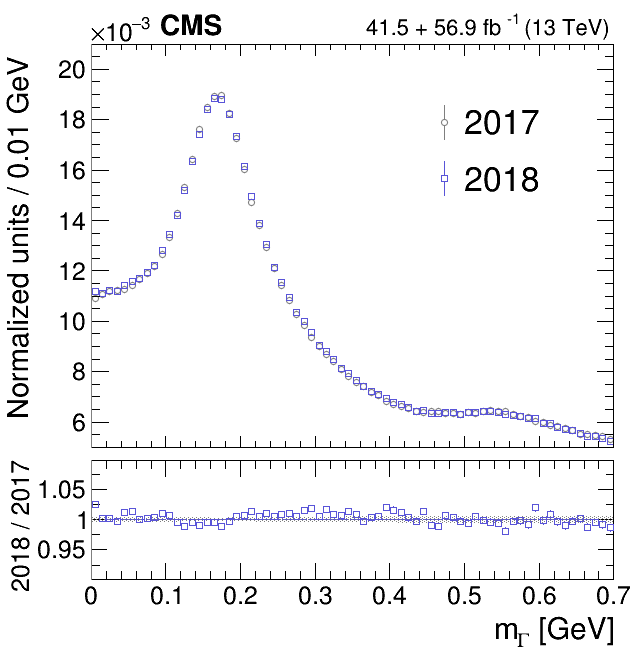

In [24]:
from hist_utils import set_hist as set_hist_ratio
hc = {}

do_trunc = True
#do_trunc = False

ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ""#"Preliminary"
#CMS_lumi.lumi_sqrtS = "41.9 fb^{-1} (13 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#CMS_lumi.lumi_sqrtS = "13 TeV" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
CMS_lumi.lumi_sqrtS = "41.5 + 56.9 fb^{-1} (13 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iPos = 11
iPos = 0
if iPos==0:
    CMS_lumi.cmsTextOffset = 0.11
    CMS_lumi.relPosX = 0.15
else:
    CMS_lumi.cmsTextOffset = 0.
    CMS_lumi.relPosX = 0.045
iPeriod = 0

err_style = 'E2'
fill_style = 3002
marker_size = 0.75 #0.6
wd, ht = int(640*1), int(680*1)
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetErrorX(0)
#ROOT.gStyle.SetOptStat(0)

k = kdata
c[k] = ROOT.TCanvas("c%s"%k,"c%s"%k,wd,ht)

pUp = ROOT.TPad("upperPad", "upperPad",.005, .300, .995, .995) # (,,Double_t xlow, Double_t ylow, Double_t xup, Double_t yup,...)
pDn = ROOT.TPad("lowerPad", "lowerPad",.005, .005, .995, .300)
pUp.Draw()
pDn.Draw()
pUp.SetMargin(14.e-02,3.e-02,2.e-02,9.e-02) # (Float_t left, Float_t right, Float_t bottom, Float_t top)
pDn.SetMargin(14.e-02,3.e-02,36.e-02,2.e-02) # (Float_t left, Float_t right, Float_t bottom, Float_t top)

pUp.cd()

# dummy hist for drawing axes
hdummy = h[k].Clone()
hdummy.Reset()
hdummy.SetName('dummy')
#hdummy = set_hist(hdummy, "m_{e,pred} [GeV]", "N_{a}", "")
hdummy = set_hist_ratio(hdummy, "m_{#Gamma} [GeV]", "f_{#Gamma}", "")
#hdummy.GetYaxis().SetTitle('Normalized units / %d MeV'%dM)
hdummy.GetYaxis().SetTitle('Normalized units / %.2f GeV'%(dM/1.e3))
hdummy.GetXaxis().SetTitle('')
hdummy.GetXaxis().SetLabelSize(0.)
hdummy.GetYaxis().SetTitleOffset(1.05)
hdummy.GetYaxis().SetTitleSize(0.07)
hdummy.GetYaxis().SetLabelSize(0.06)
hdummy.GetYaxis().SetMaxDigits(3)
hdummy.GetYaxis().SetLabelFont(42)
hdummy.GetYaxis().SetTitleFont(42)
hdummy.GetYaxis().SetLabelOffset(.01)
hdummy.SetLineColor(0)
hdummy.Draw("hist")

# Plot data
k = kdata
if h[k].Integral() > 1.:
    h[k].Scale(1./h[k].Integral())
#h[k].Scale(1./h[kdata].Integral())
# points
hc[k] = h[k].Clone()
hc[k].SetName(kdata+'errs')
hc[k].SetFillStyle(0)
hc[k].SetLineColor(14)#1
hc[k].SetMarkerColor(14)#1
hc[k].SetMarkerStyle(24)#2
#hc[k].SetMarkerSize(0.85)
hc[k].SetMarkerSize(marker_size)
hc[k].SetStats(0)
hc[k].Draw("E0p same")

# Plot MC
k = kmc
#if h[k].Integral() > 1.:
#    h[k].Scale(1./h[k].Integral())
if h[kdata].Integral() > 1.:
    h[kdata].Scale(1./h[kdata].Integral())
h[k].Scale(h[kdata].Integral()/h[kmc].Integral())
#h[k].Scale(1./h[kmc].GetEntries())
print('max:',h[k].GetMaximum())
'''
# Plot fill
hc[k] = h[k].Clone()
hc[k].SetLineColor(3)
hc[k].SetFillColor(3)
hc[k].SetFillStyle(fill_style)
hc[k].SetStats(0)
hc[k].Draw("hist same")
# Plot uncertainty
h[k].SetLineColor(9)
h[k].SetFillColor(9)
h[k].SetFillStyle(fill_style)
h[k].SetStats(0)
h[k].Draw("%s same"%err_style)
'''
# points
hc[k] = h[k].Clone()
hc[k].SetLineColor(9)#2
hc[k].SetMarkerColor(9)#2
hc[k].SetMarkerStyle(25)#24
hc[k].SetMarkerSize(marker_size)
#h[k].SetName(ks)
hc[k].SetStats(0)
hc[k].Draw("E0p same")

#if ymax_ is None and hc[k].GetBinContent(2) > 0.:
ymax_lowbin = 1 if do_trunc else 2
if dM == 100:
    ymax = 6.e6
elif dM == 10:
    ymax = 6.e5
else:
    ymax = 1.3*max(np.max([hc[kdata].GetBinContent(ib) for ib in range(ymax_lowbin, hc[kdata].GetNbinsX()+2)]),
                   np.max([hc[kmc].GetBinContent(ib) for ib in range(ymax_lowbin, hc[kmc].GetNbinsX()+2)]))
#ymax = 6.e5 #dM=10
ymax = 4.e4
ymax = 1.2*h[kdata].GetMaximum()
#ymax = 8.e5
ymax = 0.021#0.025
ymin = 0.005
#hdummy.GetYaxis().SetRangeUser(0.1, ymax)
hdummy.GetYaxis().SetRangeUser(ymin, ymax)
if do_trunc:
    hdummy.GetXaxis().SetRangeUser(0., 0.7)
else:
    hdummy.GetXaxis().SetRangeUser(-0.2, 1.2)
ROOT.gPad.RedrawAxis()

l, l2, hatch = {}, {}, {}
legend = {}

k = kdata
hatch[k] = ROOT.TGraph(2, array('d',[0.,0.]), array('d',[0.,ymax]));
hatch[k].SetLineColor(14)
hatch[k].SetLineWidth(5001)
#hatch[k].SetLineWidth(5)
hatch[k].SetFillStyle(3004)
#hatch[k].SetFillColor(14)
hatch[k].SetFillColor(12)
#ROOT.gStyle.SetHatchesLineWidth(2)
hatch[k].Draw("same")

#legend[k] = ROOT.TLegend(0.7,0.67,0.9,0.86) #(x1, y1, x2, y2)
legend[k] = ROOT.TLegend(0.67, 0.55,0.92,0.8) #(x1, y1, x2, y2)
#legend[k].AddEntry(kdata+'errs',     kdata, "lep")
#legend[k].AddEntry(h[kmc].GetName(), kmc,   "f")
legend[k].AddEntry(kdata+'errs',      kdata, "ep")
legend[k].AddEntry(hc[kmc].GetName(), kmc,   "ep")
legend[k].SetBorderSize(0)
legend[k].SetTextFont(42)
legend[k].Draw("same")

CMS_lumi.CMS_lumi(pUp, iPeriod, iPos)

##### Ratio plots on lower pad #####
pDn.cd()
pDn.SetTicky()
#pDn.SetGridy()
#'''
if do_trunc:
    fUnity = ROOT.TF1("fUnity","[0]",0.,0.7)
else:
    fUnity = ROOT.TF1("fUnity","[0]",-0.2,1.2)
fUnity.SetParameter( 0,1. )

fUnity.GetXaxis().SetTitle("m_{#Gamma} [GeV]")
fUnity.GetXaxis().SetTickLength(0.1)
fUnity.GetXaxis().SetTitleOffset(1.)
fUnity.GetXaxis().SetTitleSize(0.17) #0.16
fUnity.GetXaxis().SetLabelSize(0.14)
#if not do_trunc:
#    fUnity.GetXaxis().ChangeLabel(1,-1, 0,-1,-1,-1,"")
#    fUnity.GetXaxis().ChangeLabel(2,-1,-1,-1,-1,-1,"#font[22]{#gamma_{veto}}")

#dY = 0.199
dY = 0.099
#dY = 0.399
#fUnity.GetYaxis().SetTitle("SB/SR")
#fUnity.GetYaxis().SetTitle("Data/MC")
#fUnity.GetYaxis().SetTitle("%s / %s"%(kdata,kmc))
fUnity.GetYaxis().SetTitle("%s / %s"%(kmc, kdata))
#fUnity.GetYaxis().SetRangeUser(1.-dY,1.+dY)
fUnity.SetMaximum(1.+dY)
fUnity.SetMinimum(1.-dY)
fUnity.GetYaxis().SetNdivisions(305)
fUnity.GetYaxis().SetTickLength(0.04)
fUnity.GetYaxis().SetLabelFont(42)
fUnity.GetYaxis().SetTitleFont(42)
fUnity.GetYaxis().SetTitleOffset(.5)
fUnity.GetYaxis().SetLabelOffset(.01)
fUnity.GetYaxis().SetTitleSize(0.14)
fUnity.GetYaxis().SetLabelSize(0.14)
fUnity.GetXaxis().SetLabelFont(42)
fUnity.GetXaxis().SetTitleFont(42)
fUnity.GetXaxis().SetLabelOffset(.02)

fUnity.SetLineColor(9)
fUnity.SetLineWidth(1)
fUnity.SetLineStyle(7)
fUnity.SetTitle("")
fUnity.Draw()

# Data error bands
#k = kdata
#kr = kdata+'err'
# MC error bands
k = kmc
kr = kmc+'errs'
h[kr] = ROOT.TGraphAsymmErrors()
h[kr].SetName(kr)
for i in range(h[k].GetNbinsX()-1):
    ib = i+2
    h[kr].SetPoint(i, h[k].GetBinCenter(ib), 1.)
    h[kr].SetPointError(
        i,
        h[k].GetBinWidth(ib)/2.,
        h[k].GetBinWidth(ib)/2.,
        (h[k].GetBinError(ib)/h[k].GetBinContent(ib)),
        (h[k].GetBinError(ib)/h[k].GetBinContent(ib)),
        )
#h[kr].SetFillColor(9)
h[kr].SetFillColor(14)
h[kr].SetFillStyle(3002)
h[kr].Draw("E2 same")

# Data errors
kr = 'dataomc'+'errs'
h[kr] = h[kdata].Clone()
h[kr].Reset()
h[kr].SetName(kr)
for ib in range(1, h[k].GetNbinsX()+1):
    # 2017/2018:data/mc
    #obs = h[kdata].GetBinContent(ib)
    #obs_err = h[kdata].GetBinError(ib)
    #bkg = h[kmc].GetBinContent(ib)
    #if bkg == 0.: continue
    #bkg_err = h[kmc].GetBinError(ib)
    # 2018/2017:mc/data
    obs = h[kmc].GetBinContent(ib)
    obs_err = h[kmc].GetBinError(ib)
    bkg = h[kdata].GetBinContent(ib)
    if bkg == 0.: continue
    bkg_err = h[kdata].GetBinError(ib)
    
    h[kr].SetBinContent(ib, obs/bkg)
    h[kr].SetBinError(ib, obs_err/obs)
#h[kr].SetLineColor(9)
h[kr].SetStats(0)
#h[kr].Divide(h[kmc])
h[kr].SetMarkerStyle(25)#24
h[kr].SetMarkerSize(0.75)
h[kr].SetMarkerColor(9)#2
h[kr].SetLineColor(9) #2
h[kr].Draw("ep same")

k = kr
#l[k] = ROOT.TLine(0.135, 1.-dY, 0.135, 1.+dY) # x0,y0, x1,y1
#l[k].SetLineColor(14)
#l[k].SetLineStyle(7)
#l[k].Draw("same")

#l2[k] = ROOT.TLine(0.55, 1.-dY, 0.55, 1.+dY) # x0,y0, x1,y1
#l2[k].SetLineColor(14)
#l2[k].SetLineStyle(7)
#l2[k].Draw("same")

hatch[k] = ROOT.TGraph(2, array('d',[0.,0.]), array('d',[1.-dY,1.+dY]));
hatch[k].SetLineColor(14)
hatch[k].SetLineWidth(5001)
hatch[k].SetFillStyle(3004)
hatch[k].SetFillColor(14)
hatch[k].Draw("same")
#'''

k = kdata
c[k].Draw()
c[k].Update()
c[k].RedrawAxis()
if print_pdf:
    pass
    c[k].Print('%s/pi0-%svs%s_ma1_ptetarewgt_%s.pdf'%(plot_dir, kdata, kmc, ml_model))